In [25]:
## Import Packages
import numpy as np
import _pickle as pk
import AA as aa
from matplotlib import pyplot as plt
import matplotlib as mpl
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import scipy.stats as stats

plt.rcParams['axes.xmargin'] = 0 #default margin spacing for the edges
mpl.rc('font',size=40,**{'family':'sans-serif','sans-serif':['Arial']})
%matplotlib inline

In [26]:
Source = '/Users/johnvirgin/OneDrive - University of Waterloo/Papers/GMD_CanESM/'

In [48]:
lat = np.linspace(-87.864,87.864,64)
tropics = np.where((lat > -30) & (lat < 30))[0]
lon = np.linspace(0,357.1875,128)

y = lat*np.pi/180
coslat = np.cos(y)
coslat = np.tile(coslat,(lon.size,1)).T

land_mask = np.isnan(np.mean(pk.load(\
    open(Source+'Data/CanESM2/Climatology/CanESM2_SST_Climo.pi','rb')),axis=0))
land_valid = np.isfinite(np.mean(pk.load(\
    open(Source+'Data/CanESM2/Climatology/CanESM2_SST_Climo.pi','rb')),axis=0))
valid_stack = land_valid[tropics,:].reshape(len(tropics)*128)

In [49]:
data_sw = {}
data_lw = {}

data_sw_anom = {}
data_lw_anom = {}

data_sw_anom_trop = {}
data_lw_anom_trop = {}

mods = ['CanESM2','CanESM5_p2']
for i in range(2):
    data_sw[mods[i]] = pk.load(open(Source+\
        'Data/'+mods[i]+'/CFMIP/Tier 1/'+mods[i]+'_CFMIP_TrCLsw_FB_SRdecomp_Grid.pi','rb'))
    data_lw[mods[i]] = pk.load(open(Source+\
        'Data/'+mods[i]+'/CFMIP/Tier 1/'+mods[i]+'_CFMIP_TrCLlw_FB_SRdecomp_Grid.pi','rb'))
    
    data_sw_anom[mods[i]] = {}
    data_lw_anom[mods[i]] = {}
    
    data_sw_anom_trop[mods[i]] = {}
    data_lw_anom_trop[mods[i]] = {}
    for prop in data_sw[mods[i]].keys():
        data_sw_anom[mods[i]][prop] = np.nanmean(data_sw[mods[i]][prop]['amip-future4K']-\
                                    data_sw[mods[i]][prop]['amip-p4K'],axis=0)
        data_sw_anom[mods[i]][prop][land_mask] = np.nan
        
        data_lw_anom[mods[i]][prop] = np.nanmean(data_lw[mods[i]][prop]['amip-future4K']-\
                                    data_lw[mods[i]][prop]['amip-p4K'],axis=0)
        data_lw_anom[mods[i]][prop][land_mask] = np.nan
        
        data_sw_anom_trop[mods[i]][prop] = \
            data_sw_anom[mods[i]][prop][tropics,:].reshape(len(tropics)*128)
        data_lw_anom_trop[mods[i]][prop] = \
            data_lw_anom[mods[i]][prop][tropics,:].reshape(len(tropics)*128)

In [67]:
dSST = {}
dSST_gam = {}
dSST_norm = {}
dSST_pnom = {}
dSST_pnom_trop = {}
for i in range(len(mods)):
    dSST[mods[i]] = pk.load(open(\
        Source+'Data/'+mods[i]+'/CFMIP/Tier 1/'+mods[i]+'_dSST.pi','rb'))
    
    dSST_gam[mods[i]] = {}
    dSST_norm[mods[i]] = {}
    for exp in dSST[mods[i]].keys():
        dSST_gam[mods[i]][exp] = np.average(np.nanmean(dSST[mods[i]][exp],axis=0)[land_valid],\
                                        weights=coslat[land_valid])
        dSST_norm[mods[i]][exp] = np.nanmean(dSST[mods[i]][exp],axis=0)/dSST_gam[mods[i]][exp]
    
    
    dSST_pnom[mods[i]] = dSST_norm[mods[i]]['Pattern']-dSST_norm[mods[i]]['Uniform']
    dSST_pnom[mods[i]][land_mask == True] = np.nan
    dSST_pnom_trop[mods[i]] = dSST_pnom[mods[i]][tropics,:].reshape(len(tropics)*128)

In [68]:
r_CanESM_SW = {}
p_CanESM_SW = {}

r_CanESM_LW = {}
p_CanESM_LW = {}
for mod in data_sw.keys():
    #print('On model -',mod)
    r_CanESM_SW[mod] = {}
    p_CanESM_SW[mod] = {}
    
    r_CanESM_LW[mod] = {}
    p_CanESM_LW[mod] = {}
    for prop in data_sw[mod].keys():
        #print('\t on component -',prop)
        r_CanESM_SW[mod][prop],p_CanESM_SW[mod][prop] = stats.pearsonr(\
            dSST_pnom_trop[mod][valid_stack],data_sw_anom_trop[mod][prop][valid_stack])
        r_CanESM_LW[mod][prop],p_CanESM_LW[mod][prop] = stats.pearsonr(\
            dSST_pnom_trop[mod][valid_stack],data_lw_anom_trop[mod][prop][valid_stack])
        #print('SW')
        #print('\t\t r-value - ',round(r_CanESM_SW[mod][prop],3),\
        #      '\n \t\t p-value = ',round(p_CanESM_SW[mod][prop],5),'\n')
        
        #print('LW')
        
        #print('\t\t r-value - ',round(r_CanESM_LW[mod][prop],3),\
        #      '\n \t\t p-value = ',round(p_CanESM_LW[mod][prop],5),'\n')

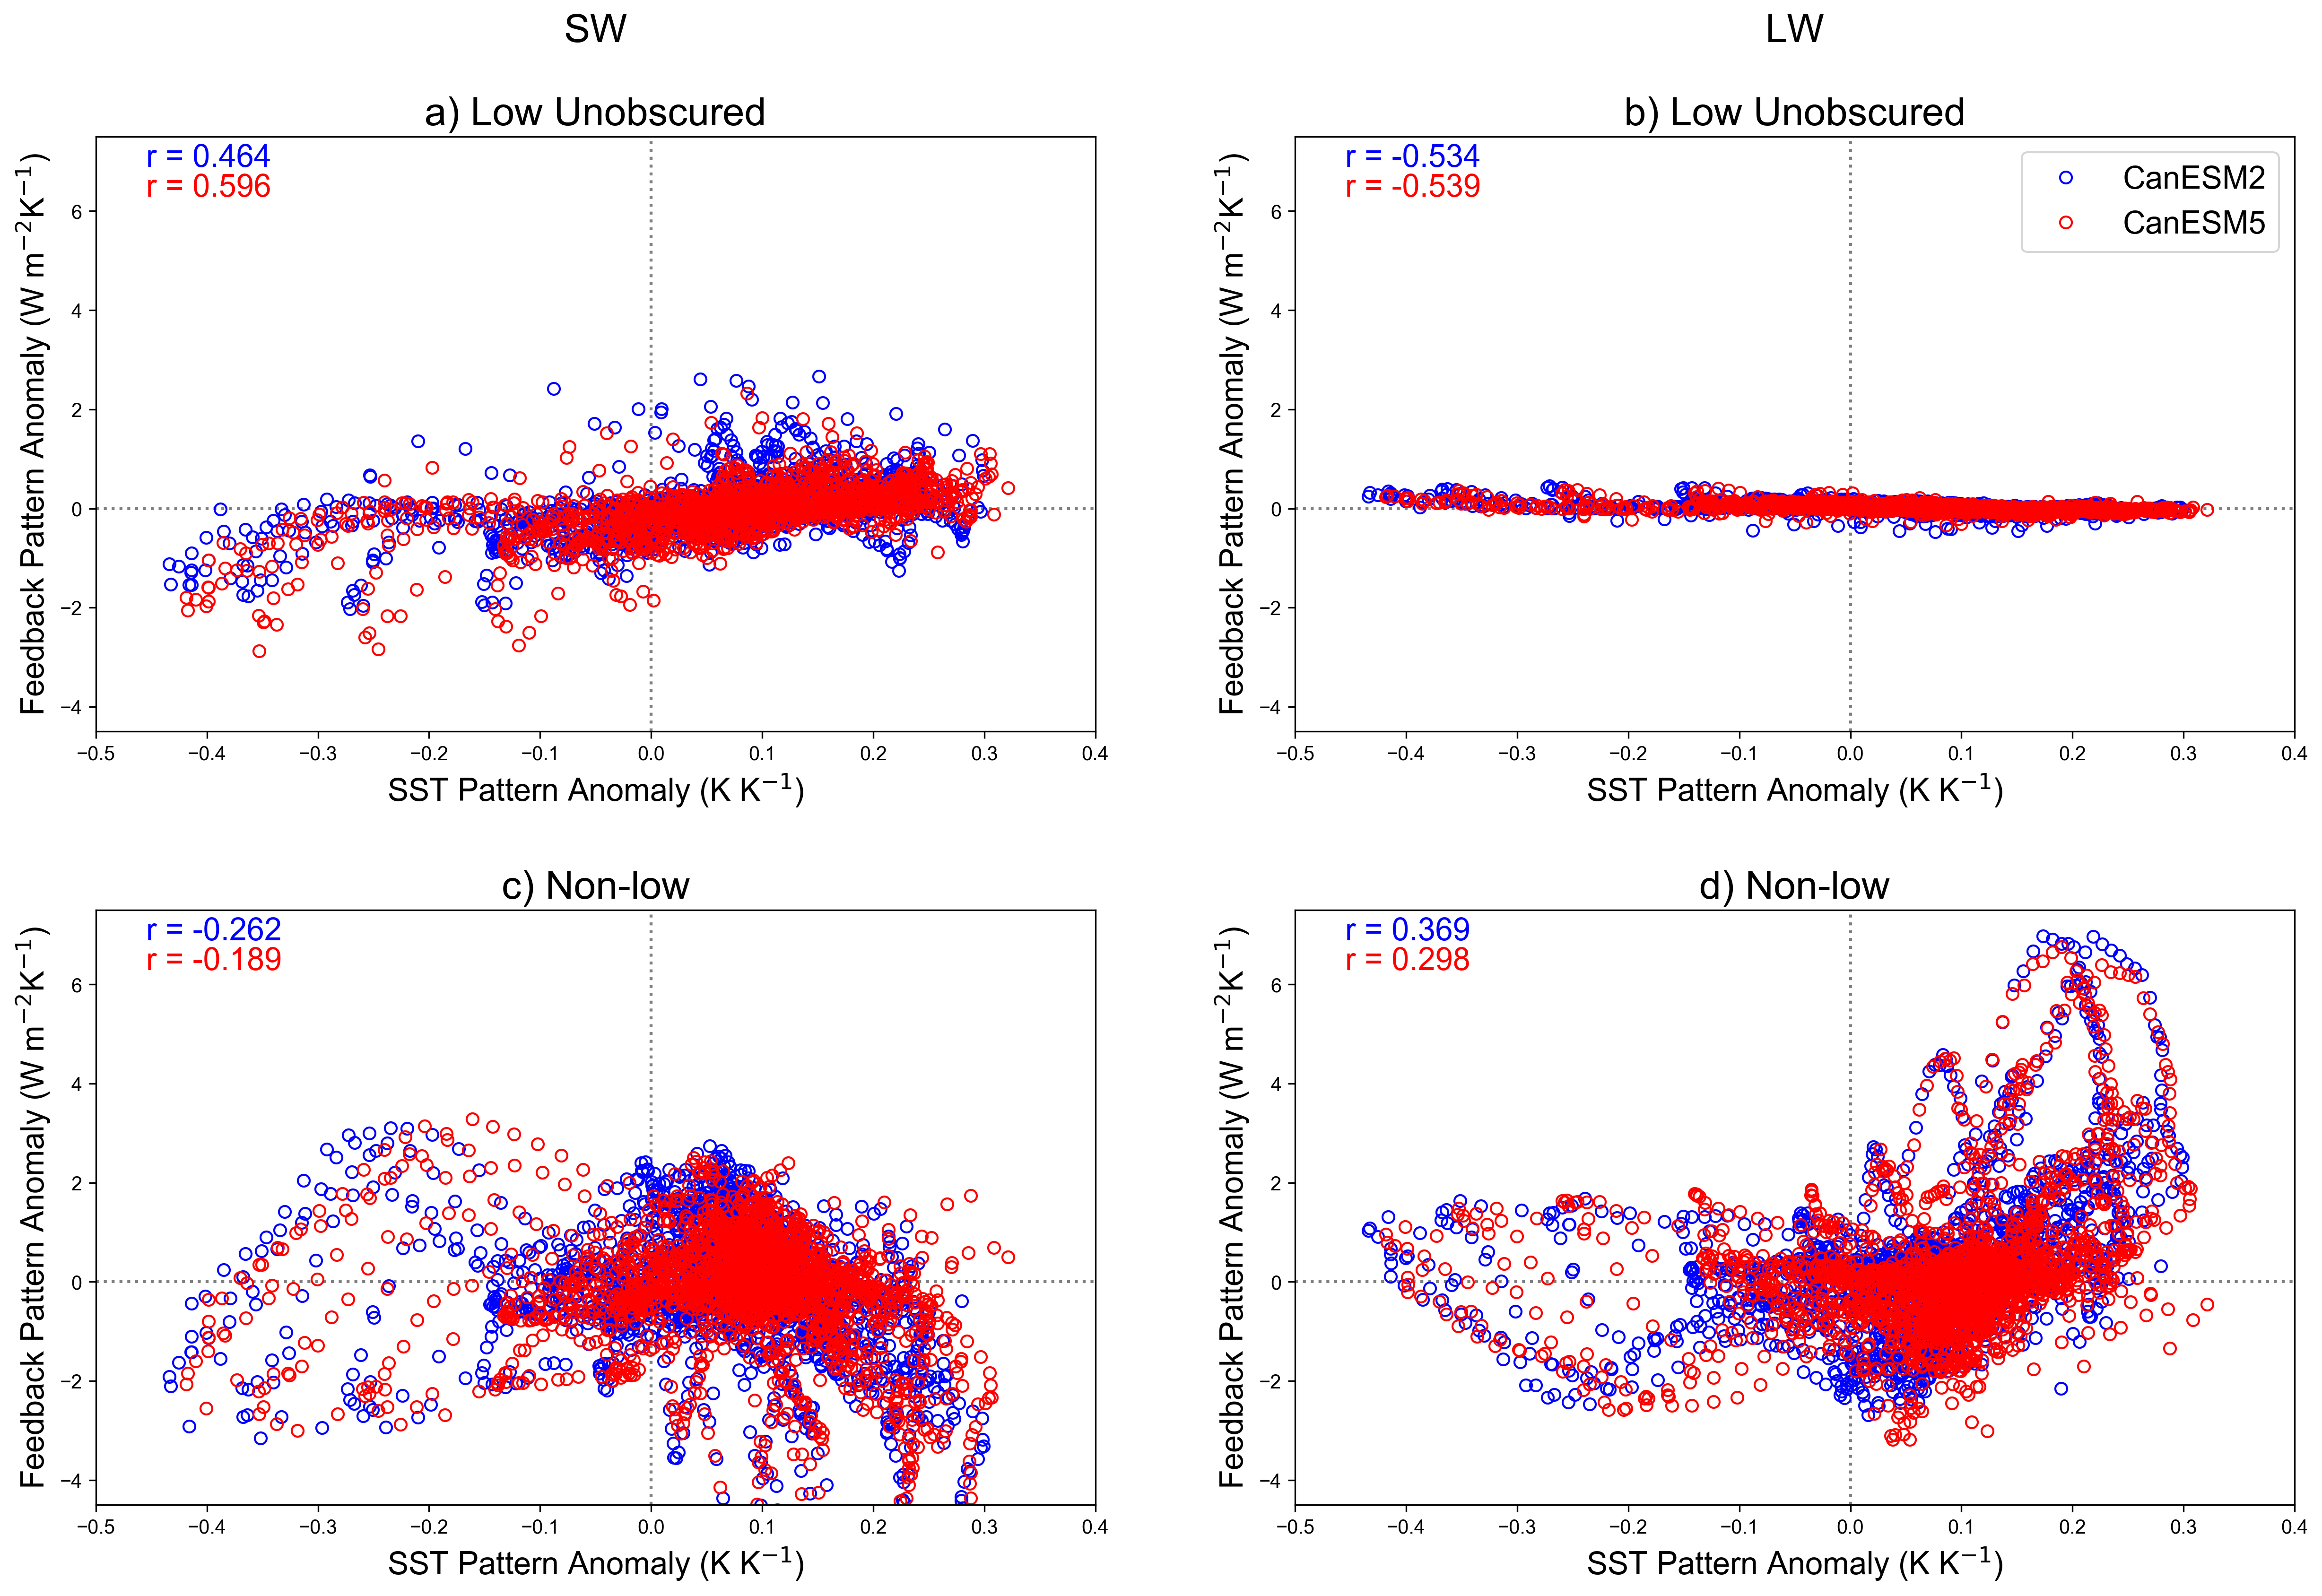

In [81]:
fig = plt.figure(figsize=(20,20),dpi=300)

ax = plt.subplot(321)
plt.title('SW\n\na) Low Unobscured',fontsize=20)
plt.axhline(0,color='grey',linestyle=':')
plt.axvline(0,color='grey',linestyle=':')
plt.plot(dSST_pnom_trop['CanESM2'],data_sw_anom_trop['CanESM2']['Low_unobscured'],\
         'o',color='blue',mfc='none')
plt.text(0.05,0.95,'r = {}'.format(round(r_CanESM_SW['CanESM2']['Low_unobscured'],3))\
         ,transform=ax.transAxes,fontsize=16,color='blue')
plt.plot(dSST_pnom_trop['CanESM5_p2'],data_sw_anom_trop['CanESM5_p2']['Low_unobscured'],\
         'o',color='red',mfc='none')
plt.text(0.05,0.90,'r = {}'.format(round(r_CanESM_SW['CanESM5_p2']['Low_unobscured'],3))\
         ,transform=ax.transAxes,fontsize=16,color='red')
plt.ylim(-4.5,7.5)
plt.xlim(-0.5,0.4)
plt.ylabel('Feedback Pattern Anomaly (W m$^{-2}$K$^{-1}$)',fontsize=16)
plt.xlabel('SST Pattern Anomaly (K K$^{-1}$)',fontsize=16);

ax = plt.subplot(322)
plt.title('LW\n\nb) Low Unobscured',fontsize=20)
plt.axhline(0,color='grey',linestyle=':')
plt.axvline(0,color='grey',linestyle=':')
plt.plot(dSST_pnom_trop['CanESM2'],data_lw_anom_trop['CanESM2']['Low_unobscured'],\
         'o',color='blue',mfc='none',label='CanESM2')
plt.text(0.05,0.95,'r = {}'.format(round(r_CanESM_LW['CanESM2']['Low_unobscured'],3))\
         ,transform=ax.transAxes,fontsize=16,color='blue')
plt.plot(dSST_pnom_trop['CanESM5_p2'],data_lw_anom_trop['CanESM5_p2']['Low_unobscured'],\
         'o',color='red',mfc='none',label='CanESM5')
plt.text(0.05,0.90,'r = {}'.format(round(r_CanESM_LW['CanESM5_p2']['Low_unobscured'],3))\
         ,transform=ax.transAxes,fontsize=16,color='red')
plt.ylim(-4.5,7.5)
plt.xlim(-0.5,0.4)
plt.legend(fontsize=16)
plt.ylabel('Feedback Pattern Anomaly (W m$^{-2}$K$^{-1}$)',fontsize=16)
plt.xlabel('SST Pattern Anomaly (K K$^{-1}$)',fontsize=16);


ax = plt.subplot(323)
plt.title('c) Non-low',fontsize=20)
plt.axhline(0,color='grey',linestyle=':')
plt.axvline(0,color='grey',linestyle=':')
plt.plot(dSST_pnom_trop['CanESM2'],data_sw_anom_trop['CanESM2']['Hi'],\
         'o',color='blue',mfc='none')
plt.text(0.05,0.95,'r = {}'.format(round(r_CanESM_SW['CanESM2']['Hi'],3))\
         ,transform=ax.transAxes,fontsize=16,color='blue')
plt.plot(dSST_pnom_trop['CanESM5_p2'],data_sw_anom_trop['CanESM5_p2']['Hi'],\
         'o',color='red',mfc='none')
plt.text(0.05,0.90,'r = {}'.format(round(r_CanESM_SW['CanESM5_p2']['Hi'],3))\
         ,transform=ax.transAxes,fontsize=16,color='red')
plt.ylim(-4.5,7.5)
plt.xlim(-0.5,0.4)
plt.ylabel('Feedback Pattern Anomaly (W m$^{-2}$K$^{-1}$)',fontsize=16)
plt.xlabel('SST Pattern Anomaly (K K$^{-1}$)',fontsize=16);

ax = plt.subplot(324)
plt.title('d) Non-low',fontsize=20)
plt.axhline(0,color='grey',linestyle=':')
plt.axvline(0,color='grey',linestyle=':')
plt.plot(dSST_pnom_trop['CanESM2'],data_lw_anom_trop['CanESM2']['Hi'],\
         'o',color='blue',mfc='none')
plt.text(0.05,0.95,'r = {}'.format(round(r_CanESM_LW['CanESM2']['Hi'],3))\
         ,transform=ax.transAxes,fontsize=16,color='blue')
plt.plot(dSST_pnom_trop['CanESM5_p2'],data_lw_anom_trop['CanESM5_p2']['Hi'],\
         'o',color='red',mfc='none')
plt.text(0.05,0.90,'r = {}'.format(round(r_CanESM_LW['CanESM5_p2']['Hi'],3))\
         ,transform=ax.transAxes,fontsize=16,color='red')
plt.ylim(-4.5,7.5)
plt.xlim(-0.5,0.4)
plt.ylabel('Feedback Pattern Anomaly (W m$^{-2}$K$^{-1}$)',fontsize=16)
plt.xlabel('SST Pattern Anomaly (K K$^{-1}$)',fontsize=16);

plt.subplots_adjust(hspace=0.3)

plt.savefig('CLDlow_v_SST_Pat_Anom.png',bbox_inches='tight')